# Sentiment Analysis

#### Importing useful libraries

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
import matplotlib.pyplot as plt
import mplcursors
import plotly.express as px
from datetime import datetime
from tabulate import tabulate


#NLP libraries 
import nltk
import re
import ssl # per risolvere problemi di certificati
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob


import yfinance as yf

#from scipy import stats as stat

### twitter_tweets dataset import

In [3]:
# Import Dataset
tweets_ds = pd.read_csv("../datasets/twitter/twitter_tweets.csv", chunksize=100000, lineterminator='\n', low_memory=False)
tweets_df = pd.concat(tweets_ds)

tweets_df.info()
tweets_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4792264 entries, 0 to 4792263
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   created_at     object
 2   author_id      int64 
 3   content        object
 4   retweet_count  int64 
 5   reply_count    int64 
 6   like_count     int64 
 7   quote_count    int64 
dtypes: int64(6), object(2)
memory usage: 292.5+ MB


(4792264, 8)

In [4]:
# we assiacure that there are no cells with null values in the date and text columns
tweets_df.dropna(axis=0 ,subset=['created_at', 'content'],inplace = True)
tweets_df.reset_index(drop= True,inplace=True)
tweets_df.shape

(4792264, 8)

In [5]:
# Check for null values
null_values = tweets_df.isnull().sum()
print("Null values in each column:\n", null_values)

# Check for duplicates
duplicate_rows = tweets_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Null values in each column:
 tweet_id         0
created_at       0
author_id        0
content          0
retweet_count    0
reply_count      0
like_count       0
quote_count      0
dtype: int64
Number of duplicate rows: 0


In [6]:
# Data cleaning 
tweets_df.drop_duplicates(inplace = True)
tweets_df.reset_index(drop=True,inplace=True)
tweets_df.shape

(4792264, 8)

In [7]:
# Setting dataset column types
tweets_df = tweets_df.convert_dtypes()
tweets_df.dtypes

tweet_id                  Int64
created_at       string[python]
author_id                 Int64
content          string[python]
retweet_count             Int64
reply_count               Int64
like_count                Int64
quote_count               Int64
dtype: object

In [8]:
# Check which of the rows don't have an actuall date in the 'date' column
def validate(date_text):
    errors = []
    for i,v in enumerate(date_text):
        try:
            datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
        except ValueError:
            errors.append(i)
    return errors

In [9]:
# Print number of date not valid
errors = validate(tweets_df['created_at'])
print('There are '+ str(len(errors)) + ' values that are not actual dates in the created_at column')

There are 0 values that are not actual dates in the created_at column


### Date of first tweet and last tweet

In [10]:
# First and last tweet in time order
# Sort the DataFrame by the 'created_at' column
tweets_df = tweets_df.sort_values(by='created_at')

# Get the first and last tweet
primo_tweet = tweets_df.iloc[0]
ultimo_tweet = tweets_df.iloc[-1]

# Print the results
print("First tweet:")
print(primo_tweet['created_at'])

print("\nLast tweet:")
print(ultimo_tweet['created_at'])

First tweet:
2017-01-06 21:42:43

Last tweet:
2022-02-23 23:57:21


### Total score calculation of tweets with weights assigned to variables such as like, quote, reply, and retweet. Sorting of tweets based on the total score in descending order

In [11]:
# Definisci pesi per like, quote, reply e retweet
peso_like = 1
peso_reply = 2
peso_retweet = 3
peso_quote = 3

# Normalizza i valori dei vari aspetti
scaler = MinMaxScaler()
tweet_features = scaler.fit_transform(tweets_df[['like_count', 'quote_count', 'reply_count', 'retweet_count']])

# Calcola il punteggio totale per ciascun tweet
tweets_df['punteggio_totale'] = (
    tweet_features[:, 0] * peso_like + 
    tweet_features[:, 1] * peso_quote + 
    tweet_features[:, 2] * peso_reply + 
    tweet_features[:, 3] * peso_retweet 
)

# Ordina il DataFrame in base al punteggio totale in ordine decrescente (più influenti)
tweets_df_sorted_desc = tweets_df.sort_values(by='punteggio_totale', ascending=False)
tweets_df_sorted_desc['data'] = pd.to_datetime(tweets_df_sorted_desc['created_at']).dt.date


print("Tweet più influenti:")
print(tweets_df_sorted_desc[['tweet_id', 'like_count', 'quote_count', 'reply_count', 'retweet_count', 'punteggio_totale', 'data']])


Tweet più influenti:
                    tweet_id  like_count  quote_count  reply_count  \
2218350  1484230264293318663      192137        10642        12575   
871365   1454653822849011713       42682         2219        13137   
2116372  1486482496883625984       20161         7196         7281   
765175   1459164143626424321       33156         5759         8598   
3895838  1433903448215408646      238764         1564          472   
...                      ...         ...          ...          ...   
533263   1464353282776870924           0            0            0   
533262   1464353288657293313           0            0            0   
533261   1464353308005605378           0            0            0   
533260   1464353317547646984           0            0            0   
4792202  1496635323744280577           0            0            0   

         retweet_count  punteggio_totale        data  
2218350          13270          5.784699  2022-01-20  
871365           76411      

### Create a graphic for the total score with month and year

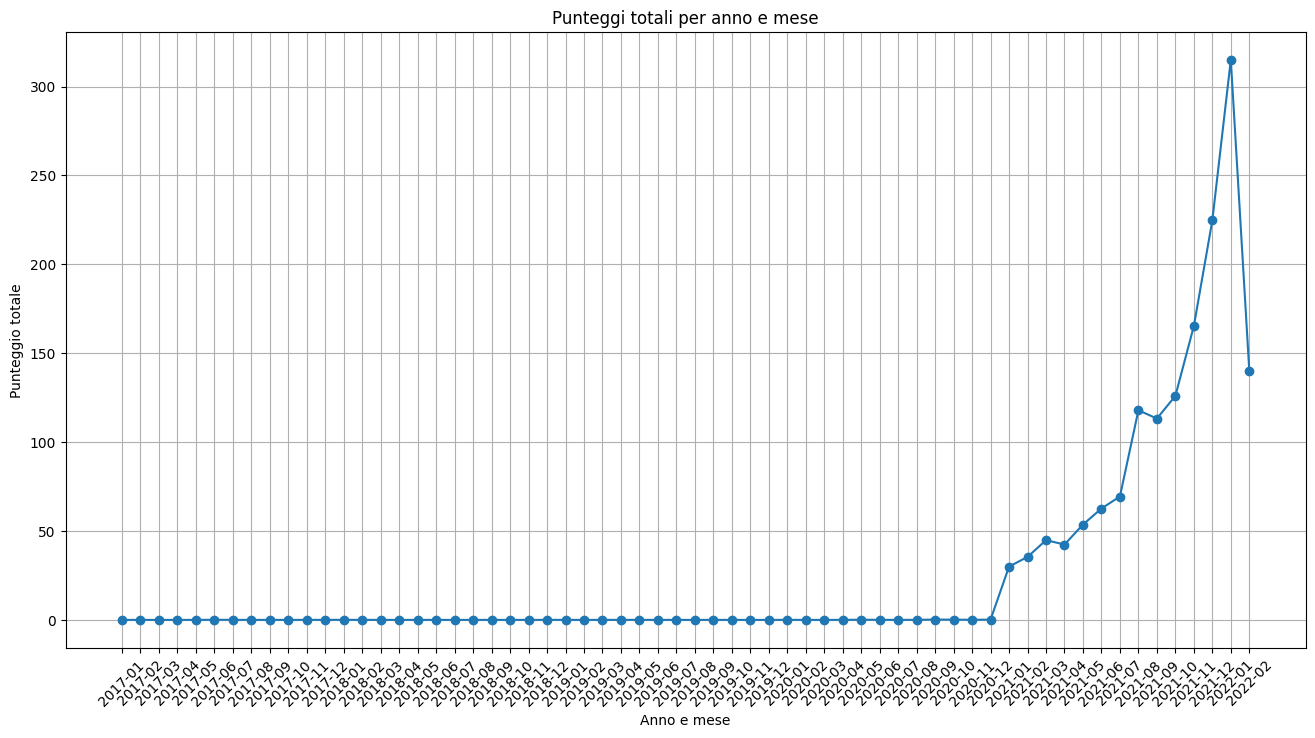

In [12]:
# Converti 'data' di nuovo in datetime per usare l'accessor dt
tweets_df_sorted_desc['data'] = pd.to_datetime(tweets_df_sorted_desc['data'])

# Calcola i punteggi totali per anno e mese
punteggi_totali_per_anno_mese = tweets_df_sorted_desc.groupby([tweets_df_sorted_desc['data'].dt.year, tweets_df_sorted_desc['data'].dt.month])['punteggio_totale'].sum()

# Converti l'indice in formato di stringa "Anno-Mese"
indice_stringa = punteggi_totali_per_anno_mese.index.map(lambda x: f"{x[0]}-{x[1]:02d}")

# Crea il grafico con dimensioni più grandi
plt.figure(figsize=(16, 8))  # Aumenta le dimensioni della figura
plt.plot(indice_stringa, punteggi_totali_per_anno_mese.values, marker='o', linestyle='-')
plt.title('Punteggi totali per anno e mese')
plt.xlabel('Anno e mese')
plt.ylabel('Punteggio totale')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Filtering

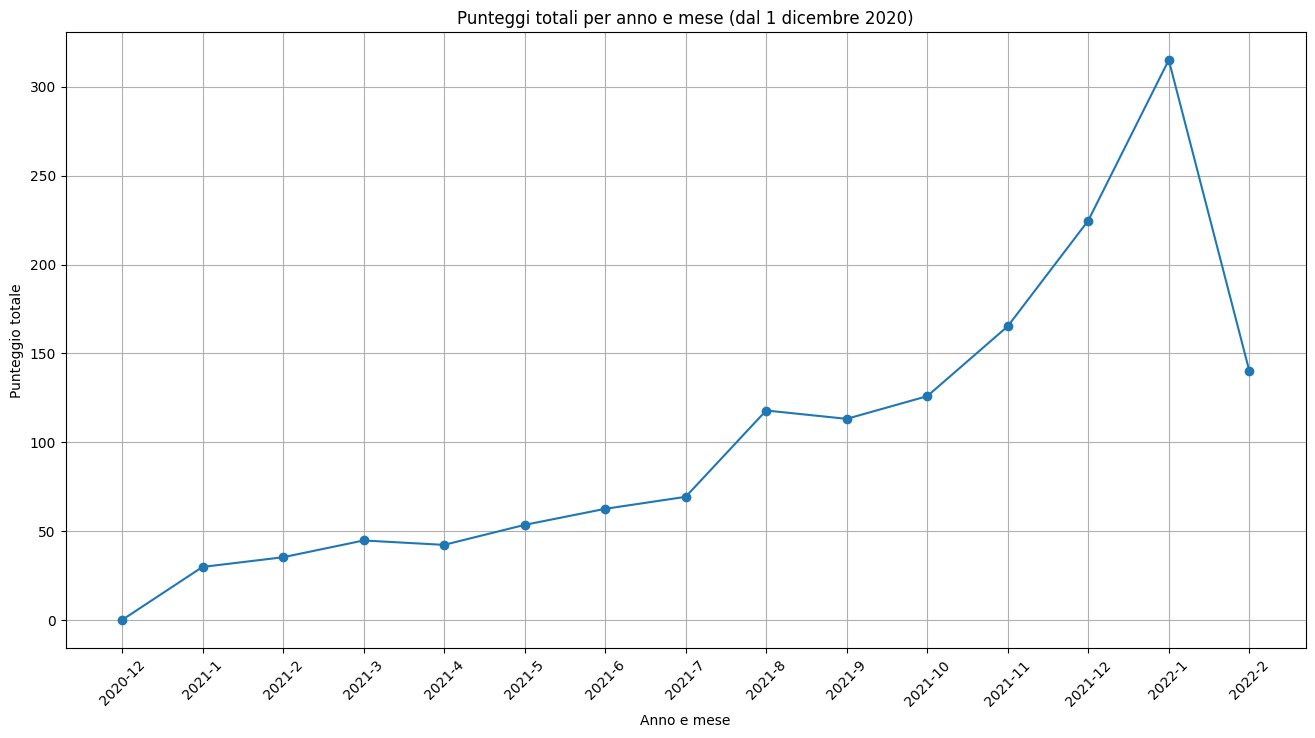

In [13]:
# Filtra i tweet dal 1 dicembre 2020 fino alla fine del dataset
tweets_filtrati = tweets_df_sorted_desc[tweets_df_sorted_desc['data'] >= pd.Timestamp('2020-12-01')]

# Calcola i punteggi totali per anno e mese dei tweet filtrati
punteggi_totali_per_anno_mese = tweets_filtrati.groupby([tweets_filtrati['data'].dt.year, tweets_filtrati['data'].dt.month])['punteggio_totale'].sum()

# Converti l'indice in formato di stringa "Anno-Mese"
indice_stringa = punteggi_totali_per_anno_mese.index.map(lambda x: f"{x[0]}-{x[1]}")

# Crea il grafico con dimensioni più grandi
plt.figure(figsize=(16, 8))
plt.plot(indice_stringa, punteggi_totali_per_anno_mese.values, marker='o', linestyle='-')
plt.title('Punteggi totali per anno e mese (dal 1 dicembre 2020)')
plt.xlabel('Anno e mese')
plt.ylabel('Punteggio totale')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [14]:
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format='%Y-%m-%d %H:%M:%S')
tweets_df_final = tweets_df.loc[(tweets_df['created_at'] >= '2020-12-01')].reset_index(drop=True)
tweets_df_final.shape
# Visualizzare la forma del dataframe filtrato
print(tweets_df_final.shape)

(4779585, 9)


### twitter_tweet_hashtag dataset import

In [15]:
# Import Dataset
hashtag_ds = pd.read_csv("../datasets/twitter/twitter_tweet_hashtag.csv", chunksize=100000, lineterminator='\n', low_memory=False)
hashtag_df = pd.concat(hashtag_ds)

hashtag_df.info()
hashtag_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337482 entries, 0 to 7337481
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   tweet_id  int64 
 1   hashtag   object
dtypes: int64(1), object(1)
memory usage: 112.0+ MB


(7337482, 2)

In [16]:
# we assiacure that there are no cells with null values in the date and text columns
hashtag_df.dropna(axis=0 ,subset=['tweet_id', 'hashtag'],inplace = True)
hashtag_df.reset_index(drop= True,inplace=True)
hashtag_df.shape

(7337480, 2)

In [17]:
# Check for null values
null_values = hashtag_df.isnull().sum()
print("Null values in each column:\n", null_values)

# Check for duplicates
duplicate_rows = hashtag_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Null values in each column:
 tweet_id    0
hashtag     0
dtype: int64
Number of duplicate rows: 0


In [18]:
# Data cleaning 
hashtag_df.drop_duplicates(inplace = True)
hashtag_df.reset_index(drop=True,inplace=True)
hashtag_df.shape

(7337480, 2)

In [19]:
# Setting dataset column types
hashtag_df = hashtag_df.convert_dtypes()
hashtag_df.dtypes

tweet_id             Int64
hashtag     string[python]
dtype: object

### Hashtags list

In [20]:
# Assicura che la colonna 'hashtags' sia di tipo stringa
hashtag_df['hashtag'] = hashtag_df['hashtag'].astype(str)

# Crea una lista di tutti gli hashtag
all_hashtags = []
for hashtags_str in hashtag_df['hashtag']:
    # Rimuove eventuali caratteri indesiderati e divide per ottenere una lista di hashtag
    hashtags = [tag.strip("[]'") for tag in hashtags_str.split(', ')]
    all_hashtags.extend(hashtags)

# Rimuove eventuali caratteri speciali dagli hashtag
all_hashtags = [tag.strip("#") for tag in all_hashtags]

# Conta la frequenza degli hashtag
hashtags_frequenza = pd.Series(all_hashtags).value_counts()
# Conta il numero totale di hashtag
total_hashtags = len(hashtags_frequenza)
print("Total number of hashtags:", total_hashtags)

# Filtra gli hashtag che contengono almeno una delle parole chiave relative agli NFT
nft_keywords = ["nft", "cryptopunks", "bayc", "nfts", "nftcommunity", "nftart", "nftcollector", "opensea", "ethereum", "cryptopunk"]
filtered_hashtags = hashtags_frequenza[hashtags_frequenza.index.str.contains('|'.join(nft_keywords))]

# Stampa gli hashtag rilevanti insieme alla loro frequenza
print("Hashtags related to NFT and their counts:")
print(filtered_hashtags)


Total number of hashtags: 185131
Hashtags related to NFT and their counts:
nft                517794
cryptopunks        310915
bayc               306206
nfts               287180
nftcommunity       224366
                    ...  
nftchampion             1
parodynft               1
nftfollectibles         1
nftthaiㅜ                1
nftcn                   1
Name: count, Length: 10024, dtype: int64


### Hashtags più influenti visibili graficamente

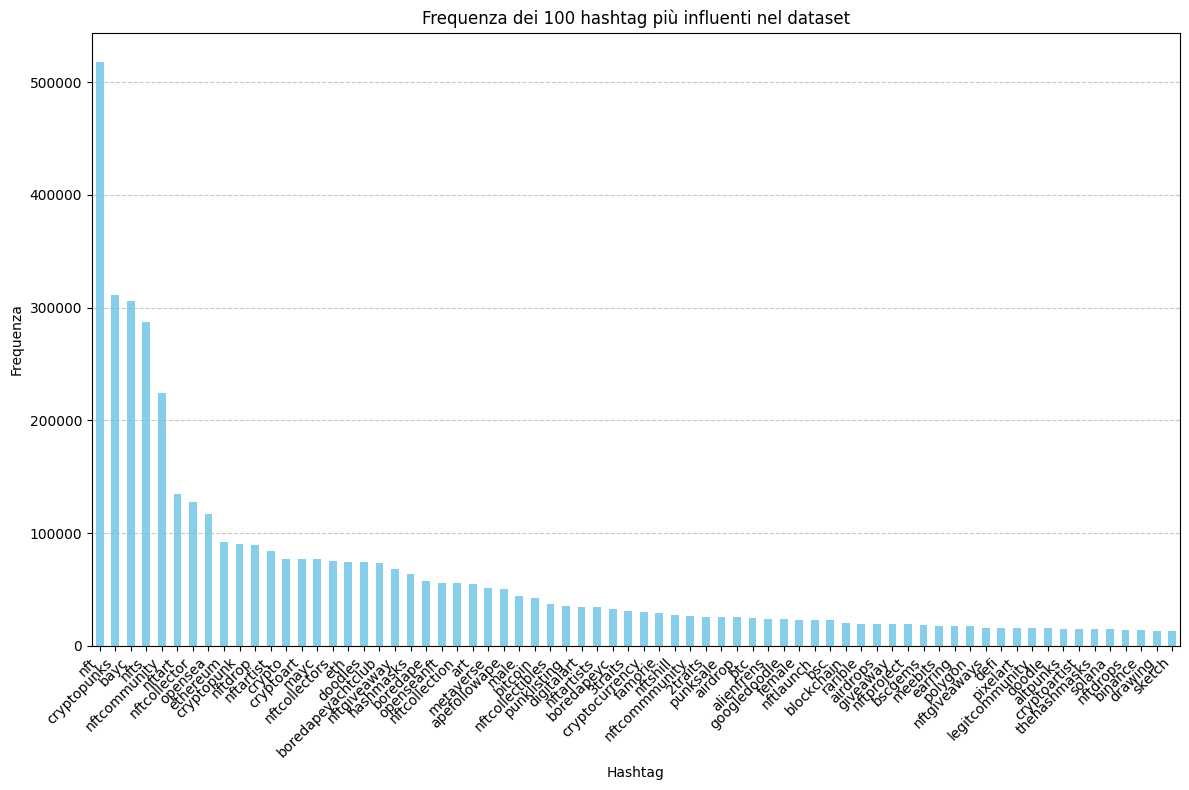

In [21]:
# Per vedere gli hashtags più frequenti nel grafico (70)
hashtags_influenti = hashtags_frequenza.head(70)

# Crea un grafico a barre per visualizzare la frequenza degli hashtag più influenti
plt.figure(figsize=(12, 8))
hashtags_influenti.plot(kind='bar', color='skyblue')
plt.title('Frequenza dei 100 hashtag più influenti nel dataset')
plt.xlabel('Hashtag')
plt.ylabel('Frequenza')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Filtraggio lista hashtag

In [22]:
# Crea un dataframe dai conti degli hashtag
hashtag_df = pd.DataFrame(hashtags_frequenza.items(), columns=['hashtag', 'count'])
# Ordina il dataframe per conteggio
hashtag_df = hashtag_df.sort_values(by='count', ascending=False)

# Prendi solo i primi 25 hashtag
top_hashtags = hashtag_df.head(25)

# Visualizza i primi 20 hashtag
print("Top 25 Hashtags:")
print(top_hashtags)

Top 25 Hashtags:
              hashtag   count
0                 nft  517794
1         cryptopunks  310915
2                bayc  306206
3                nfts  287180
4        nftcommunity  224366
5              nftart  134723
6        nftcollector  127437
7             opensea  117422
8            ethereum   92566
9          cryptopunk   90684
10            nftdrop   89965
11          nftartist   83959
12             crypto   77336
13          cryptoart   76762
14               mayc   76687
15      nftcollectors   75089
16                eth   74478
17            doodles   74450
18  boredapeyachtclub   73813
19        nftgiveaway   68274
20          hashmasks   63935
21           boredape   57365
22         openseanft   55646
23      nftcollection   55617
24                art   54583


<Figure size 1200x600 with 0 Axes>

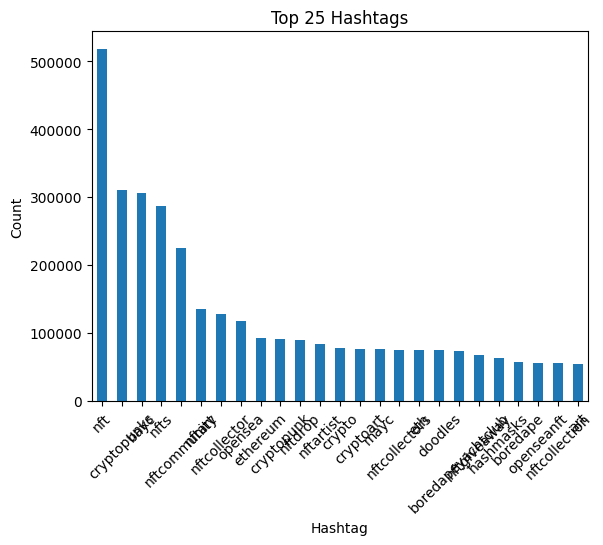

In [23]:
# Visualizza i primi 25 hashtag graficamente
plt.figure(figsize=(12, 6))
top_hashtags.plot(kind='bar', x='hashtag', y='count', legend=False)
plt.title('Top 25 Hashtags')
plt.ylabel('Count')
plt.xlabel('Hashtag')
plt.xticks(rotation=45)
plt.show()

### Analisi temporale: n tweet per giorno

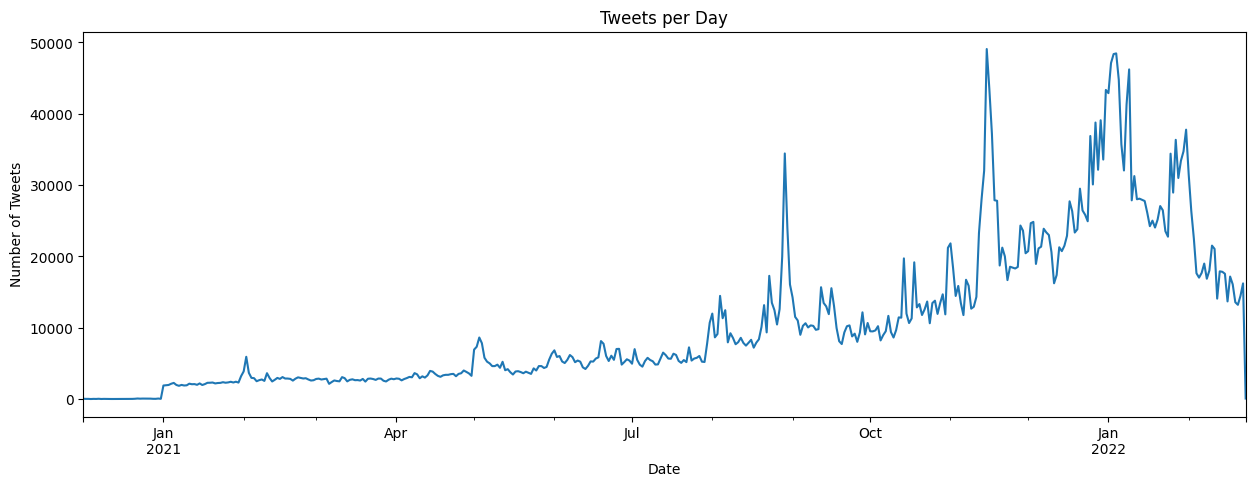

In [24]:
# Analisi temporale per il numero di tweet per giorno
tweets_df_final.set_index('created_at', inplace=True)

# Resample per giorno e conta i tweet
tweets_per_day = tweets_df_final['tweet_id'].resample('D').count()

# Grafico dei tweet per giorno
plt.figure(figsize=(15, 5))
tweets_per_day.plot()
plt.title('Tweets per Day')
plt.ylabel('Number of Tweets')
plt.xlabel('Date')
plt.show()


### Contare e visualizzare i Tweet con almeno un hashtag che ci interessano (top hashtags)

In [25]:
# Definisci la funzione per contare il numero di hashtag di interesse in un tweet
def count_interest_hashtags(tweet_content):
    count = sum(1 for hashtag in top_hashtags['hashtag'] if hashtag in tweet_content)
    return count

# Applica la funzione per contare gli hashtag a ogni tweet
tweets_df_final['num_interest_hashtags'] = tweets_df_final['content'].apply(count_interest_hashtags)

# Conta il numero di tweet che contengono almeno uno degli hashtag di interesse
num_tweets_with_interest_hashtags = tweets_df_final[tweets_df_final['num_interest_hashtags'] > 0].shape[0]

# Visualizza il numero di tweet che contengono almeno uno degli hashtag di interesse
print(f"Number of tweets with at least one interest hashtag: {num_tweets_with_interest_hashtags}")


Number of tweets with at least one interest hashtag: 2604393


### Filtraggio tweets df final con solo almeno uno degli hashtag di interesse salvati nella variabile tweets_with_interest_hashtags

In [29]:
# Filtra il DataFrame per includere solo i tweet con almeno uno degli hashtag di interesse
tweets_with_interest_hashtags = tweets_df_final[tweets_df_final['num_interest_hashtags'] > 0]

# Visualizza il DataFrame risultante
print(tweets_with_interest_hashtags)

# controllo sul numero di tweet che contiene la nuova variabile
num_tweets_with_interest_hashtags = tweets_with_interest_hashtags.shape[0]
print("Numero di tweet nella variabile 'tweets_with_interest_hashtags':", num_tweets_with_interest_hashtags)

                                tweet_id            author_id  \
created_at                                                      
2020-12-01 00:06:03  1333562970291511299            722037084   
2020-12-01 00:07:12  1333563259174187009            722037084   
2020-12-01 00:53:00  1333574785998217217            594609832   
2020-12-01 00:53:46  1333574979343015936            594609832   
2020-12-01 01:01:07  1333576830297780225             25276592   
...                                  ...                  ...   
2022-02-23 23:10:11  1496623453574737927  1315596439389691904   
2022-02-23 23:13:35  1496624306650062854  1364796117851000833   
2022-02-23 23:38:51  1496630664547995653  1364796117851000833   
2022-02-23 23:39:03  1496630715227664388  1035703436300283906   
2022-02-23 23:57:21  1496635323744280577            732899923   

                                                               content  \
created_at                                                               
2020-1

### Visualizzazione della distribuzione dei Tweet con e senza hashtag di Interesse
### NB: Vedere quanti tweets possiedono gli hashtag del nostro filtraggio rispetto a quelli totali

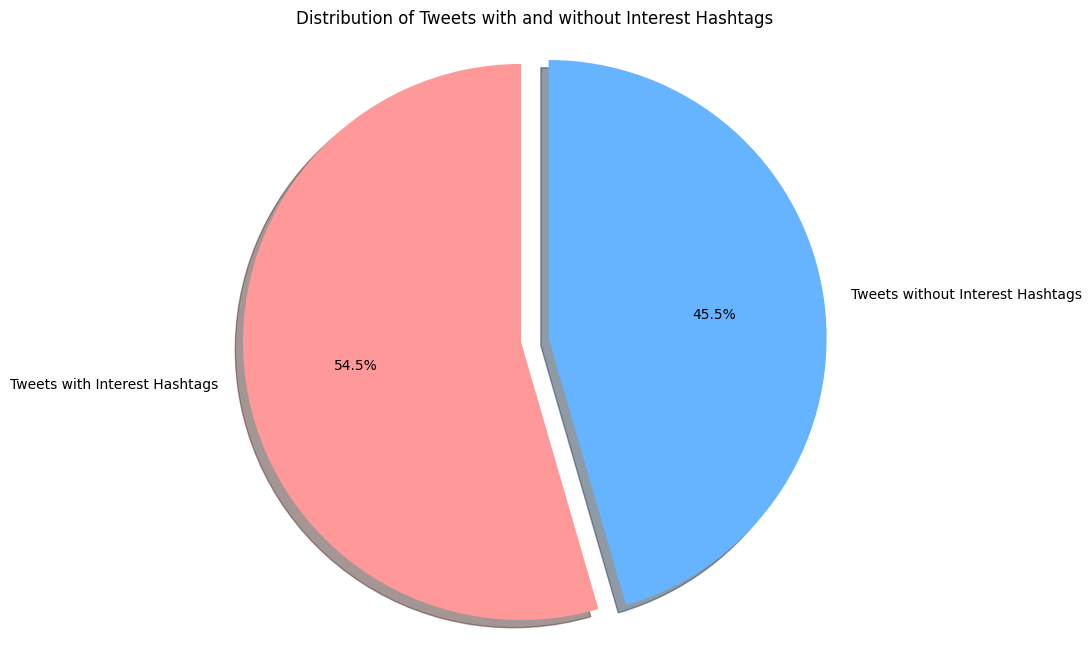

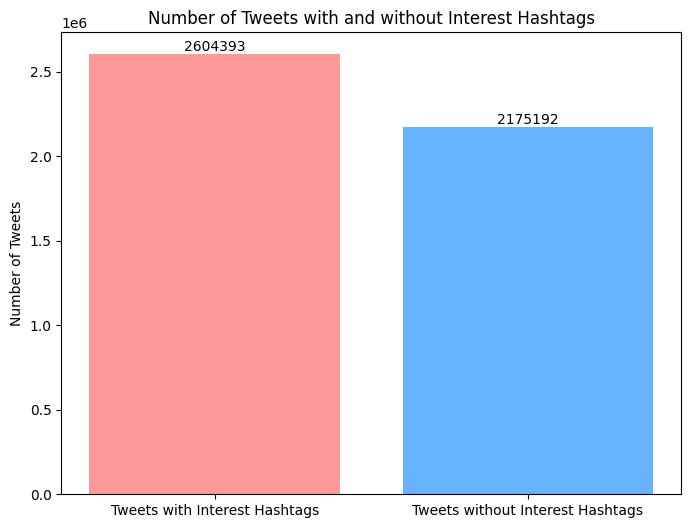

In [27]:
# Conta il numero totale di tweet
total_tweets = tweets_df_final.shape[0]

# Crea i dati per la visualizzazione
labels = ['Tweets with Interest Hashtags', 'Tweets without Interest Hashtags']
sizes = [num_tweets_with_interest_hashtags, total_tweets - num_tweets_with_interest_hashtags]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # esplode la prima fetta (Tweets with Interest Hashtags)

# Grafico a torta
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Tweets with and without Interest Hashtags')
plt.show()

# Grafico a barre
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, sizes, color=colors)
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets with and without Interest Hashtags')

# Aggiungi i numeri sopra le barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()

### Filtrare i tweet contenenti solo i primi 25 hashtag più influenti

In [28]:
# Prendi solo i primi 25 hashtag più influenti
top_hashtags_list = top_hashtags['hashtag'].tolist()

# Filtra i tweet che contengono almeno uno dei top 25 hashtag
tweets_df_final['contains_top_hashtag'] = tweets_df_final['hashtags'].apply(lambda x: any(hashtag in x for hashtag in top_hashtags_list))

# Filtra i tweet che contengono almeno uno dei top 25 hashtag
filtered_tweets_df = tweets_df_final[tweets_df_final['contains_top_hashtag']]

# Visualizza la forma del dataframe filtrato
print(filtered_tweets_df.shape)

# Visualizza i primi 5 tweet filtrati per verifica
print(filtered_tweets_df[['content', 'hashtags']].head())

# Stampa il numero di tweet nel dataframe filtrato
num_tweets_with_top_hashtags = filtered_tweets_df.shape[0]
print(f"Number of tweets with at least one top 25 hashtag: {num_tweets_with_top_hashtags}")


KeyError: 'hashtags'

In [ ]:
'''
# Estrarre gli hashtag dai tweet
tweets_df_final['hashtags'] = tweets_df_final['content'].apply(lambda tweet: re.findall(r"#(\w+)", tweet))

# Visualizza i primi 5 tweet con i loro hashtag per verificare
tweets_df_final[['content', 'hashtags']].head()
'''

,content,hashtags
created_at,,
2020-12-01 00:06:03,I am participating in an #epic #LitecoinCash #...,"[epic, LitecoinCash, giveaway, cryptocurrency,..."
2020-12-01 00:07:12,Join @litecoincash Discord: https://t.co/C7qLS...,"[cryptopunk, epic, LitecoinCash, giveaway, cry..."
2020-12-01 00:53:00,I am participating in an #epic #LitecoinCash #...,"[epic, LitecoinCash, giveaway, cryptocurrency,..."
2020-12-01 00:53:46,Join @litecoincash Discord: https://t.co/ahRtO...,"[cryptopunk, epic, LitecoinCash, giveaway, cry..."
2020-12-01 00:57:08,Help me win #epic #LitecoinCash #giveaway! htt...,"[epic, LitecoinCash, giveaway]"


In [ ]:
'''
# Prendi solo i primi 25 hashtag più influenti
top_25_hashtags = top_hashtags['hashtag'].tolist()

# Verifica se un tweet contiene uno degli hashtag di interesse
tweets_df_final['contains_top_hashtag'] = tweets_df_final['hashtags'].apply(lambda hashtags: any(tag in top_25_hashtags for tag in hashtags))

# Visualizza i primi 5 tweet con il nuovo flag per verificare
tweets_df_final[['content', 'hashtags', 'contains_top_hashtag']].head()
'''

,content,hashtags,contains_top_hashtag
created_at,,,
2020-12-01 00:06:03,I am participating in an #epic #LitecoinCash #...,"[epic, LitecoinCash, giveaway, cryptocurrency,...",True
2020-12-01 00:07:12,Join @litecoincash Discord: https://t.co/C7qLS...,"[cryptopunk, epic, LitecoinCash, giveaway, cry...",True
2020-12-01 00:53:00,I am participating in an #epic #LitecoinCash #...,"[epic, LitecoinCash, giveaway, cryptocurrency,...",True
2020-12-01 00:53:46,Join @litecoincash Discord: https://t.co/ahRtO...,"[cryptopunk, epic, LitecoinCash, giveaway, cry...",True
2020-12-01 00:57:08,Help me win #epic #LitecoinCash #giveaway! htt...,"[epic, LitecoinCash, giveaway]",False


In [ ]:
'''
# Filtra i tweet che contengono almeno uno dei top 25 hashtag
filtered_tweets_df = tweets_df_final[tweets_df_final['contains_top_hashtag']]

# Visualizza la forma del dataframe filtrato
print(filtered_tweets_df.shape)

# Visualizza i primi 5 tweet filtrati per verifica
filtered_tweets_df[['content', 'hashtags']].head()

# Stampa il numero di tweet nel dataframe filtrato
num_tweets_with_top_hashtags = filtered_tweets_df.shape[0]
print(f"Number of tweets with at least one top 25 hashtag: {num_tweets_with_top_hashtags}")
'''

(634504, 11)
Number of tweets with at least one top 25 hashtag: 634504


### Tweet con il maggior numero di hashtag di interesse (indicati precedentemente)

In [ ]:
# Trova il massimo numero di hashtag di interesse tra tutti i tweet
max_interest_hashtags = tweets_df_final['num_interest_hashtags'].max()

# Filtra i tweet che hanno il massimo numero di hashtag di interesse
tweets_with_max_interest_hashtags = tweets_df_final[tweets_df_final['num_interest_hashtags'] == max_interest_hashtags].copy()

# Seleziona solo le colonne desiderate
selected_columns = ['tweet_id', 'author_id', 'content']

# Crea una copia dei dati per evitare SettingWithCopyWarning
tweets_with_max_interest_hashtags_selected = tweets_with_max_interest_hashtags[selected_columns].copy()

# Aggiungi una colonna per mostrare gli hashtag citati in ciascun tweet
tweets_with_max_interest_hashtags_selected['mentioned_hashtags'] = tweets_with_max_interest_hashtags_selected['content'].apply(lambda x: [tag.strip("#") for tag in x.split() if tag.startswith("#")])

# Ordina i tweet per data di creazione in ordine decrescente
tweets_with_max_interest_hashtags_selected = tweets_with_max_interest_hashtags_selected.sort_index(ascending=False)

# Visualizza i tweet con il massimo numero di hashtag di interesse e gli hashtag menzionati
print("Tweets with the maximum number of interest hashtags and mentioned hashtags:")
print(tweets_with_max_interest_hashtags_selected)

# Calcola il numero di tweet con il massimo numero di hashtag di interesse
num_tweets_with_max_interest_hashtags = len(tweets_with_max_interest_hashtags_selected)

# Visualizza il numero di questi tweet
print(f"Number of tweets with the maximum number of interest hashtags: {num_tweets_with_max_interest_hashtags}")

# Raggruppa i tweet per autore e contali
author_tweet_counts = tweets_with_max_interest_hashtags_selected.groupby('author_id').size().sort_values(ascending=False)

# Visualizza i tweet con il massimo numero di hashtag di interesse per ogni autore
print("Tweets with the maximum number of interest hashtags by author:")
print(author_tweet_counts)

# Visualizza il numero di autori con il massimo numero di tweet
print(f"Number of authors with the maximum number of interest hashtags: {len(author_tweet_counts)}")



Tweets with the maximum number of interest hashtags and mentioned hashtags:
                                tweet_id            author_id  \
created_at                                                      
2021-10-09 15:04:12  1446854011953557509  1437073473365553157   

                                                               content  \
created_at                                                               
2021-10-09 15:04:12  @valleyTheCat @Ape_ethereum The bounty hunters...   

                                                    mentioned_hashtags  
created_at                                                              
2021-10-09 15:04:12  [nft, nfts, nftart, nftartist, nftcollector, n...  
Number of tweets with the maximum number of interest hashtags: 1
Tweets with the maximum number of interest hashtags by author:
author_id
1437073473365553157    1
dtype: int64
Number of authors with the maximum number of interest hashtags: 1


### Pulizia testo in preparazione alla Sentiment Analysis ###

In [ ]:
# Pulizia del testo
tweets_df_final['content'] = tweets_df_final['content'].str.replace("(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"," ")
tweets_df_final_clean = tweets_df_final.copy()
tweets_df_final_clean.head()

<>:2: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\['
/var/folders/z0/w05phkg900j6dsx_95__2tz80000gn/T/ipykernel_896/266713833.py:2: SyntaxWarning: invalid escape sequence '\['
  tweets_df_final['content'] = tweets_df_final['content'].str.replace("(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"," ")


,tweet_id,author_id,content,retweet_count,reply_count,like_count,quote_count,punteggio_totale,num_interest_hashtags,hashtags,contains_top_hashtag
created_at,,,,,,,,,,,
2020-12-01 00:06:03,1333562970291511299,722037084,I am participating in an #epic #LitecoinCash #...,0,0,0,0,0.0,3,"[epic, LitecoinCash, giveaway, cryptocurrency,...",True
2020-12-01 00:07:12,1333563259174187009,722037084,Join @litecoincash Discord: https://t.co/C7qLS...,0,0,0,0,0.0,2,"[cryptopunk, epic, LitecoinCash, giveaway, cry...",True
2020-12-01 00:53:00,1333574785998217217,594609832,I am participating in an #epic #LitecoinCash #...,0,0,0,0,0.0,3,"[epic, LitecoinCash, giveaway, cryptocurrency,...",True
2020-12-01 00:53:46,1333574979343015936,594609832,Join @litecoincash Discord: https://t.co/ahRtO...,0,0,0,0,0.0,2,"[cryptopunk, epic, LitecoinCash, giveaway, cry...",True
2020-12-01 00:57:08,1333575826823131136,594609832,Help me win #epic #LitecoinCash #giveaway! htt...,0,0,0,0,0.0,0,"[epic, LitecoinCash, giveaway]",False


In [ ]:
# punkt serve per tokenizzare il testo e pulirlo
nltk.download('punkt')
# stopwords serve per rimuovere le parole comuni che non sono rilevanti per l'analisi
nltk.download('stopwords')
# wordnet serve per le operazioni di stemming
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [ ]:
# Disabilita la verifica SSL per scaricare i token di nltk, altrimenti non funziona
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# Tokenizzazione per dividere il testo in parole per poterle analizzare singolarmente
tweets_df_final_clean['content'] = tweets_df_final_clean.apply(lambda row: word_tokenize(row['content']), axis=1)
tweets_df_final_clean.head()

KeyboardInterrupt: 

In [ ]:
# Rimozione delle stopwords
stopwords = set(stopwords.words('english'))
tweets_df_final_clean['content'] = tweets_df_final_clean.apply(lambda row: (" ".join([word for word in row['content'] if word not in stop_words])),axis=1)


AttributeError: 'set' object has no attribute 'words'

In [ ]:
# DA UNIRE ALLA CELLA SOPRA
tweets_df_final_clean.head() 

,tweet_id,author_id,content,retweet_count,reply_count,like_count,quote_count,punteggio_totale,num_interest_hashtags
created_at,,,,,,,,,
2020-12-01 00:06:03,1333562970291511299,722037084,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3
2020-12-01 00:07:12,1333563259174187009,722037084,Join @ litecoincash Discord : https : //t.co/C...,0,0,0,0,0.0,2
2020-12-01 00:53:00,1333574785998217217,594609832,I participating # epic # LitecoinCash # giveaw...,0,0,0,0,0.0,3
2020-12-01 00:53:46,1333574979343015936,594609832,Join @ litecoincash Discord : https : //t.co/a...,0,0,0,0,0.0,2
2020-12-01 00:57:08,1333575826823131136,594609832,Help win # epic # LitecoinCash # giveaway ! ht...,0,0,0,0,0.0,0


In [ ]:
# Lemmatizzazione per ridurre le parole alla loro forma base
# lemmatizer = WordNetLemmatizer()
# tweets_df_final_clean['content'] = tweets_df_final_clean.apply(lambda row: [lemmatizer.lemmatize(word) for word in row['content']], axis=1)

### Popolarità e soggettività dei tweet ###

In [ ]:
# Calcola la popolarità e la soggettività di ciascun tweet
tweets_df_final_clean[['polarity', 'subjectivity']] = tweets_df_final_clean['content'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

# Rinomina il df per la sentiment analysis
tweets_df_sentiment = tweets_df_final_clean.copy()
tweets_df_sentiment.head()

KeyboardInterrupt: 

### Assegnazione del sentiment

In [ ]:
# Crea una nuova colonna 'Sentiment' basata sulla polarità
tweets_df_sentiment['Sentiment'] = tweets_df_sentiment['polarity'].apply(lambda x: "Positive" if x > 0 else ("Negative" if x < 0 else "Neutral"))

# Rimuov colonne non necessarie 
# AIUTO, QUALI POTREMMO TOGLIERE?????
# tweets_df_sentiment.drop(['subjectivity'], axis=1, inplace=True)

# Visualizza i primi risultati
tweets_df_sentiment.head()


### Formattazione delle date

In [ ]:
# Converte la colonna 'created_at' in formato datetime
tweets_df_sentiment['created_at'] = pd.to_datetime(tweets_df_sentiment['created_at'], format='%Y-%m-%d %H:%M:%S')

tweets_df_sentiment.info()

### Filtraggio delle date

In [ ]:
# Imposta la data di inizio e fine per filtrare i tweet nel DataFrame con i periodi più importanti analizzati precedentemente
first_date = pd.to_datetime('2020-12-01').date()
last_date = pd.to_datetime('2022-02-23').date() # Data dell'ultimo tweet nel dataset
# Filtra i tweet per il periodo specificato
tweets_df_sentiment_period = tweets_df_sentiment.loc[(tweets_df_sentiment['date'] >= first_date) & (tweets_df_sentiment['date'] <= last_date)].reset_index(drop=True)
tweets_df_sentiment_period.info()

### Analisi del sentiment per ciascun giorno

In [ ]:
# Raggruppa per data e sentiment e conta il numero di tweet per ciascuna combinazione
grouped_data = tweets_df_sentiment_period.groupby(['date', 'Sentiment']).size().reset_index(name='tweet_count')
print(grouped_data)

### PROVAAAAAA ###

In [ ]:
'''
# Funzione per l'analisi del sentiment
def analyze_sentiment(text):
    # Crea un oggetto TextBlob dal testo del tweet
    blob = TextBlob(text)
    # Restituisce la polarità del sentiment
    return blob.sentiment.polarity

# Applica la funzione di analisi del sentiment al contenuto dei tweet
tweets_df['sentiment_polarity'] = tweets_df['content'].apply(analyze_sentiment)

# Stampa i tweet con la polarità del sentiment
print("Sentiment Analysis dei tweet:")
print(tweets_df[['tweet_id', 'content', 'sentiment_polarity']])
'''

KeyboardInterrupt: 